<h1>Enrich Cells to be Run Through Trained OSM Completeness Model</h1>
<p>After training an OSM completeness model and generating a collection of 250-m by 250-m cells over a region of interest, load that collection into this notebook to join features (e.g., VIIRS nighttime lights, NDVI, WSF) to it. After this notebook is finished, the output can be run through the trained OSM completeness model in the ApplyModel notebook.</p>

In [1]:
import rasterio
from rasterio.plot import show
from rasterstats import zonal_stats, utils
import gdal, gdalconst
import json
from shapely.geometry import shape, box, mapping, Point, Polygon
import geopandas as gpd
import pandas as pd
import math
import osmnx as ox
import numpy as np

In [25]:
import ee
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/0gFOEB4rbcQ8rnGLojVniw1V2J7_3-KHiXwYxZJh94bahQNQXmTgy7Q

Successfully saved authorization token.


In [26]:
#class for GeoJSON feature collections. To complete analysis need two:
#1. training data from Observable notebook
#2. grid data that wil be run through trained model and output
class Features:
    
    def __init__(self, filename=''):
        self.filename = filename
        self.polygons = []
        
        if filename=='':
            return
        
        with open(filename) as f:
            self.data = json.load(f)
        try:
            #uncomment to do a quick test with only 100 features
            #self.features = self.data['features'][0:100]
            self.features = self.data['features']
        except:
            print("JSON file did not have features array")
            
    def getPolygons(self):
        for feature in self.features:
            g = shape(feature['geometry']).buffer(0)
            self.polygons.append(g)
        print(len(self.polygons))
        return self.polygons
    
    #used if creating own grid, not reading JSON file in __init__
    def setData(self, df):
        self.data = mapping(df.geometry)
        #don't need bbox for anything so delete it to reduce output file size
        del self.data['bbox']
        for feature in self.data['features']:
            del feature['bbox']
        self.features = self.data['features']
    
    def projectGeoDataFrame(self, *args):
        if len(args) > 0:
            df = args[0]
        else:
            df = self.geoDataFrame
        
        avg_longitude = (self.bounds[0] + self.bounds[2])/2
        utm_zone = int(math.floor((avg_longitude + 180) / 6.) + 1)
        utm_crs = f'+proj=utm +zone={utm_zone} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
   
        # project the GeoDataFrame to the UTM CRS
        self.geoDataFrameProjected = df.to_crs(utm_crs)
    
        return self.geoDataFrameProjected
    
    def createGeoDataFrame(self):
        self.geoDataFrame = gpd.GeoDataFrame({
            'geometry': self.polygons
        })
        self.geoDataFrame.crs = "EPSG:4326"
        return self.geoDataFrame
        
    def getBounds(self):
        self.bounds = self.geoDataFrame.total_bounds
        return self.bounds
    
    def getClippingBox(self):
        if not hasattr(self, 'bounds'):
            self.getBounds()
        bbox = box(self.bounds[0], self.bounds[1], self.bounds[2], self.bounds[3])
        self.bbox = bbox
        self.clippingBox = {'type': 'Feature', 'properties': {}, 'geometry': mapping(bbox)}
        return self.clippingBox

In [27]:
class Raster:
    
    def __init__(self, filename):
        self.filename = filename
        
    def dataFromBounds(self, band, bounds):
        with rasterio.open(self.filename) as src:
            self.noData = src.nodatavals[0]
            window = rasterio.windows.from_bounds(bounds[0],bounds[1],bounds[2],bounds[3], src.transform)
            self.boundsData = src.read(band, window=window)
            self.boundsTransform = src.window_transform(window)

In [28]:
def returnClippedLength(spatialIndex, DF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = DF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.length).sum()

In [29]:
def returnClippedPoints(spatialIndex, DF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = DF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return len(preciseClip.index)

In [30]:
def returnClippedArea(spatialIndex, buildingDF, clippingPoly):
    possible_matches_index = list(spatialIndex.intersection(clippingPoly.bounds))
    possible_matches = buildingDF.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(clippingPoly)]
    if (precise_matches.empty):
        return 0
    preciseClip = gpd.clip(precise_matches, clippingPoly)
    return (preciseClip.area).sum()

In [31]:
def eeForest(features):

    ee.Initialize()
    gfcImage = ee.Image("UMD/hansen/global_forest_change_2018_v1_6")
    FCL0018 = gfcImage.select(['loss']).eq(1).rename('fcloss0018')
    FC00 = gfcImage.select(['treecover2000']).gte(20)
    FC18 = FC00.subtract(FCL0018).rename('FC18')
    FC18Area = FC18.multiply(ee.Image.pixelArea()).rename('FC18Area')
    forestSum = FC18Area.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

    return forestSum.getInfo()

In [32]:
def maskEdge(img):
    mask = img.select(0).unitScale(-25, 5).multiply(255).toByte().connectedComponents(ee.Kernel.rectangle(1,1), 100);
    return img.updateMask(mask.select(0))

def eeTexture(features, JSONob):
   
    ee.Initialize()
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD').filterBounds(JSONob.clippingBox['geometry']).filterMetadata('instrumentMode', 'equals', 'IW')
    .select(['VV', 'angle']))

    se1 = s1.select(0).filterDate('2019-01-01', '2019-07-31').median()

    textureMean = se1.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 10
        #maxPixels= 1e9
    )
    return textureMean.getInfo()

In [33]:
def eeSlope(features):
   
    ee.Initialize()
    srtm = ee.Image("CSP/ERGo/1_0/Global/SRTM_mTPI")
    slope = ee.Terrain.slope(srtm).rename('slope')
    slopeMean = slope.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.mean(),
        scale= 270
        #maxPixels= 1e9
    )
    return slopeMean.getInfo()

In [34]:
#only return 2019 for now
def eeVIIRSNTL(features):
    
    ee.Initialize()
    viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG")

    #2019 viirs
    viirs_2019_mean = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').mean().rename('viirs_2019_mean')
    viirs_2019_median = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').median().rename('viirs_2019_median')
    viirs_2019_max = viirs.select('avg_rad').filterDate('2019-01-01','2019-07-01').max().rename('viirs_2019_max')

    VIIRS2019 = viirs_2019_mean.addBands(viirs_2019_median).addBands(viirs_2019_max)

    stats2019 = VIIRS2019.reduceRegions(
        collection= ee.FeatureCollection(features),
        reducer= ee.Reducer.sum(),
        scale= 500
        #maxPixels= 1e9
    )

   
    return stats2019.getInfo()

In [35]:
def maskS2clouds(image):
    qa = image.select('QA60')

    #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    #Both flags should be set to zero, indicating clear conditions.
    mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(
            qa.bitwiseAnd(cirrusBitMask).eq(0)))

    #Return the masked and scaled data, without the QA bands.
    return (image.updateMask(mask) #.divide(10000)
      .select("B.*")
      .copyProperties(image, ["system:time_start"]))

def eeIndices(features, JSONob):
   
    ee.Initialize()
    #Map the function over one year of data and take the median.
    #Load Sentinel-2 TOA reflectance data.
    collection = (ee.ImageCollection('COPERNICUS/S2')
        .filterDate('2019-01-01', '2019-07-31')
        #Pre-filter to get less cloudy granules.
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
        .map(maskS2clouds))

    composite = collection.median().clip(ee.Feature(JSONob.clippingBox))#.int()  
    ndbi = composite.normalizedDifference(['B11','B8']).rename('ndbi')
    ndvi = composite.normalizedDifference(['B8','B4']).rename('ndvi')
    savi = composite.expression(
        '1.5 * (NIR-RED) / (NIR+RED+0.5)', {
          'NIR': composite.select('B8'),
          'RED': composite.select('B4')
    }).rename('savi').float()
    urbanIndex = composite.normalizedDifference(['B12','B8']).rename('ui')
    sen2AllIndices = ndvi.addBands(ndbi).addBands(savi).addBands(urbanIndex)
    #Calculate Indices
    finalIndices = sen2AllIndices.reduceRegions(
    collection= ee.FeatureCollection(features),
    reducer= ee.Reducer.sum(),
    scale= 10,
    )
    return finalIndices.getInfo()

<p>Download <a href ="https://data.humdata.org/search?organization=facebook&q=high%20resolution%20population&ext_page_size=25&sort=score%20desc%2C%20if(gt(last_modified%2Creview_date)%2Clast_modified%2Creview_date)%20desc">Facebook population data</a> or <a href="https://www.worldpop.org/geodata/listing?id=29">WorldPop</a> data for your area of interest and insert the paths into the cell below.</p>

In [14]:
#Change file name to point to file containing polygons
#If processing a large region, one approach is to split it into smaller chunks 
#In testing, a file of 440000 features took 4 hours to complete
filename="chunk0"
gridJSON = Features("path_to_polygon_file\\"+filename+".json")
gridPolys=gridJSON.getPolygons()
gridDF = gridJSON.createGeoDataFrame()
gridFeatures = gridJSON.features
gridBounds = gridJSON.getBounds()
gridClip = gridJSON.getClippingBox()

100


In [15]:
#project grid to UTM zone for accurate area calculations
gridDFProjected = gridJSON.projectGeoDataFrame(gridDF)

In [16]:
###############################################
# processing regular grid JSON
###############################################
fbPath = r'path_to_facebook'
wpPath = r'path_to_worldpop'
wsfPath = r'path_to_wsf'

fbRaster = Raster(fbPath)
#arguments are band number and bounds list
fbRaster.dataFromBounds(1, gridBounds)

wpRaster = Raster(wpPath)
wpRaster.dataFromBounds(1, gridBounds)

WSFRaster = Raster(wsfPath)
WSFRaster.dataFromBounds(1, gridBounds)

zonalStatsWSF = zonal_stats(gridPolys, WSFRaster.boundsData, affine = WSFRaster.boundsTransform, stats=['count'], nodata=0)
zonalStatsFB = zonal_stats(gridPolys, fbRaster.boundsData, affine = fbRaster.boundsTransform, stats=['sum'], nodata=fbRaster.noData)
zonalStatsWP = zonal_stats(gridPolys, wpRaster.boundsData, affine = wpRaster.boundsTransform, stats=['sum'], nodata=wpRaster.noData)

popToAddFB = [x['sum'] for x in zonalStatsFB]
popToAddWP = [x['sum'] for x in zonalStatsWP]
popToAddWSF = [x['count'] for x in zonalStatsWSF]
print("done grid ingest and population")

done grid ingest and population


In [18]:
#google earth engine can only process 5000 features at a time. Split into 4000 feature chunks to be safe and avoid errors
gridFeatures = gridJSON.features
nFeatures = len(gridFeatures)
batchSize = 4000
nCalcs = int(math.floor(nFeatures/batchSize) + 1)

sections = list(range(0,batchSize*nCalcs,batchSize))

In [19]:
#N, S, E, W
Ggrid = ox.graph_from_bbox(gridBounds[-1], gridBounds[-3], gridBounds[2], gridBounds[0], network_type='drive')
print('done creating graph')
Ggrid_projected = ox.project_graph(Ggrid)
print('done projecting graph')

done creating graph
done projecting graph


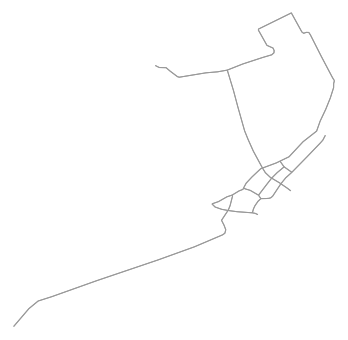

(<Figure size 430.537x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x237c3db64c0>)

In [20]:
# clean up the intersections and extract their xy coords
intersectionsGrid = ox.clean_intersections(Ggrid_projected, tolerance=15, dead_ends=False)
pointsGrid = np.array([point.xy for point in intersectionsGrid])
ox.plot_graph(Ggrid_projected,node_alpha=0)

In [36]:
pointGeometriesGrid = []
for point in pointsGrid:
    pointGeometriesGrid.append(Point(point))

nodeDFGrid = gpd.GeoDataFrame({'geometry':pointGeometriesGrid})
nodeSIGrid = nodeDFGrid.sindex

In [37]:
geometriesGrid = []
for u, v, data in Ggrid_projected.edges(keys=False, data=True):
    if 'geometry' in data:
        geometriesGrid.append(data['geometry'])

In [23]:
roadDFGrid = gpd.GeoDataFrame({'geometry':geometriesGrid})
roadSIGrid = roadDFGrid.sindex

gridLengths = []
gridNodes = []

for i,row in enumerate(gridDFProjected.geometry):
    gridLengths.append(returnClippedLength(roadSIGrid, roadDFGrid , row))
    gridNodes.append(returnClippedPoints(nodeSIGrid, nodeDFGrid, row))
print("done grid roads")

done grid roads


In [38]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        forestJSON = eeForest(toProcess)
    else:
        forestJSON['features'] = forestJSON['features'] + eeForest(toProcess)['features']

print(len(forestJSON['features']))
print("done grid forest")

0
100
done grid forest


In [39]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        textureJSON = eeTexture(toProcess, gridJSON)
    else:
        textureJSON['features'] = textureJSON['features'] + eeTexture(toProcess, gridJSON)['features']

print(len(textureJSON['features']))
print("done grid texture")

0
100
done grid texture


In [40]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        slopeJSON = eeSlope(toProcess)
    else:
        slopeJSON['features'] = slopeJSON['features'] + eeSlope(toProcess)['features']

print(len(slopeJSON['features']))
print("done grid slope")

0
100
done grid slope


In [41]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        VIIRS2019JSON = eeVIIRSNTL(toProcess)
    else:
        VIIRS2019JSON['features'] = VIIRS2019JSON['features'] + eeVIIRSNTL(toProcess)['features']

print(len(VIIRS2019JSON['features']))
print("done grid VIIRS NTL")

0
100
done grid VIIRS NTL


In [42]:
for section in sections:
    print(section)
    if section == sections[-1]:
        toProcess = gridFeatures[section::]
    else:
        toProcess = gridFeatures[section:section+batchSize]
        
    if section == 0:
        indicesJSON = eeIndices(toProcess, gridJSON)
    else:
        indicesJSON['features'] = indicesJSON['features'] + eeIndices(toProcess, gridJSON)['features']

print(len(indicesJSON['features']))
print("done grid indices")

0
100
done grid indices


In [43]:
gridFootprints = ox.footprints_from_polygon(gridJSON.bbox)
print("done getting footprints")
avg_longitudeGrid = (gridBounds[0] + gridBounds[2])/2
print(avg_longitudeGrid)
utm_zoneGrid = int(math.floor((avg_longitudeGrid + 180) / 6.) + 1)
utm_crsGrid = f'+proj=utm +zone={utm_zoneGrid} +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
print("projecting")
# project the GeoDataFrame to the UTM CRS
gridFootprintsProjected = gridFootprints.to_crs(utm_crsGrid)
print("generating spatial index")
gridFootprintsSindex = gridFootprintsProjected.sindex

done getting footprints
83.92971625096459
projecting
generating spatial index


In [44]:
gridAreas = []
for i,row in enumerate(gridDFProjected.geometry):
    gridAreas.append(returnClippedArea(gridFootprintsSindex, gridFootprintsProjected, row))

In [45]:
def returnFeatureVals(featureString, variable):
    return [x['properties'][featureString] for x in variable['features']]

In [46]:
gridFeatureDict = {
    'ndbi':returnFeatureVals('ndbi', indicesJSON),
    'ndvi':returnFeatureVals('ndvi', indicesJSON),
    'savi':returnFeatureVals('savi', indicesJSON),
    'ui':returnFeatureVals('ui', indicesJSON),
    'viirs':returnFeatureVals('viirs_2019_max', VIIRS2019JSON),
    'slope':returnFeatureVals('mean', slopeJSON),
    'texture':returnFeatureVals('mean', textureJSON),
    'forest':returnFeatureVals('sum', forestJSON),
    'popFB':popToAddFB,
    'popWP':popToAddWP,
    'popWSF':popToAddWSF,
    'roads':gridLengths,
    'nodes':gridNodes,
    'area':gridAreas
}

gridDF = pd.DataFrame.from_dict(gridFeatureDict)
gridGeoDF = gpd.GeoDataFrame(gridDF,crs = 4326, geometry=gridJSON.polygons)
gridGeoDF = gridGeoDF.fillna(0)

In [47]:
gridFeatureDF = gridGeoDF[['ndbi','ndvi','savi','ui','viirs','slope','texture','forest','popFB','popWP','roads','nodes','popWSF']]
gridTargetDF = gridGeoDF['area']
#round output to 3 decimal places to reduce file size
gridGeoDF=gridGeoDF.round(3)

In [33]:
gridGeoDF.to_file("path_to_output\\"+filename+"output.json", driver="GeoJSON")